In [1]:
import pandas as pd

df = pd.read_csv("../test_validation5/dr_adult/all_results.csv")

In [2]:
df.columns

Index(['timestamp', 'exp_name', 'dataset', 'method', 'seed', 'q', 'agg_repeat',
       'x_sensitive', 'sens_keys', 'sens_thresh', 'epochs', 'batch_size', 'lr',
       'lambda_fair', 'n_low', 'n_low_frac', 'shrink_smallest_frac',
       'shrink_seed', 'gamma', 'gf_max_iters', 'gf_C', 'gf_fairness',
       'mc_alpha', 'mc_lambda', 'mc_max_iter', 'mc_randomized',
       'mc_use_oracle', 'seq_alpha', 'seq_max_iter', 'red_constraint',
       'red_eps', 'red_max_iter', 'red_base', 'reg_lambda', 'reg_base',
       'x_sensitive_mode', 'used_S_cols', 'dropped_cols', 'start_time',
       'end_time', 'time_prepare_data_sec', 'time_run_method_sec',
       'time_metrics_sec', 'time_total_sec', 'V_stats', 'V_mode_[1]',
       'sup_mmd_over_V_[1]', 'sup_w1_over_V_[1]', 'worst_spd_over_V_[1]',
       'mean_spd_over_V_[1]', 'worst_weighted_spd_over_V_[1]',
       'mean_weighted_spd_over_V_[1]', 'V_mode_[2]', 'sup_mmd_over_V_[2]',
       'sup_w1_over_V_[2]', 'worst_spd_over_V_[2]', 'mean_spd_over_V_[2]'

In [10]:
df[["n_low_frac"]]

,n_low_frac
0,0.2
1,0.2


In [5]:
df[["lambda_fair",'V_mode_[1]','sup_mmd_over_V_[1]', 'sup_w1_over_V_[1]', 'worst_spd_over_V_[1]',
       'mean_spd_over_V_[1]', 'worst_weighted_spd_over_V_[1]',
       'mean_weighted_spd_over_V_[1]', "accuracy"]]

,lambda_fair,V_mode_[1],sup_mmd_over_V_[1],sup_w1_over_V_[1],worst_spd_over_V_[1],mean_spd_over_V_[1],worst_weighted_spd_over_V_[1],mean_weighted_spd_over_V_[1],accuracy
0,10.0,"[('af_exact_k', 1, 'pos=6527', 'neg=3242'), ('...",0.023987,0.045054,0.045870,0.018287,0.020890,0.014753,0.786877
1,0.0,"[('af_exact_k', 1, 'pos=6527', 'neg=3242'), ('...",0.193828,0.388548,0.217984,0.102821,0.099274,0.084716,0.857406


In [6]:
df[["lambda_fair", 'V_mode_[2]', 'sup_mmd_over_V_[2]',
       'sup_w1_over_V_[2]', 'worst_spd_over_V_[2]', 'mean_spd_over_V_[2]',
       'worst_weighted_spd_over_V_[2]', 'mean_weighted_spd_over_V_[2]', "accuracy"]]

,lambda_fair,V_mode_[2],sup_mmd_over_V_[2],sup_w1_over_V_[2],worst_spd_over_V_[2],mean_spd_over_V_[2],worst_weighted_spd_over_V_[2],mean_weighted_spd_over_V_[2],accuracy
0,10.0,"[('af_exact_k', 2, 'pos=5690', 'neg=4079'), ('...",0.021460,0.042762,0.044666,0.030366,0.018197,0.02853,0.786877
1,0.0,"[('af_exact_k', 2, 'pos=5690', 'neg=4079'), ('...",0.179496,0.364794,0.295669,0.192777,0.091083,0.17806,0.857406


In [7]:
df[["lambda_fair", 'V_mode_[3]', 'sup_mmd_over_V_[3]', 'sup_w1_over_V_[3]',
       'worst_spd_over_V_[3]', 'mean_spd_over_V_[3]',
       'worst_weighted_spd_over_V_[3]', 'mean_weighted_spd_over_V_[3]', "accuracy"]]

,lambda_fair,V_mode_[3],sup_mmd_over_V_[3],sup_w1_over_V_[3],worst_spd_over_V_[3],mean_spd_over_V_[3],worst_weighted_spd_over_V_[3],mean_weighted_spd_over_V_[3],accuracy
0,10.0,"[('af_exact_k', 3, 'pos=2683', 'neg=7086'), ('...",0.021913,0.038327,0.041717,0.037175,0.015203,0.037495,0.786877
1,0.0,"[('af_exact_k', 3, 'pos=2683', 'neg=7086'), ('...",0.168528,0.359591,0.303572,0.262639,0.083027,0.257260,0.857406


In [8]:
df[["lambda_fair",'V_mode_[1, 2]', 'sup_mmd_over_V_[1, 2]', 'sup_w1_over_V_[1, 2]',
       'worst_spd_over_V_[1, 2]', 'mean_spd_over_V_[1, 2]',
       'worst_weighted_spd_over_V_[1, 2]', 'mean_weighted_spd_over_V_[1, 2]', "accuracy"]]

,lambda_fair,"V_mode_[1, 2]","sup_mmd_over_V_[1, 2]","sup_w1_over_V_[1, 2]","worst_spd_over_V_[1, 2]","mean_spd_over_V_[1, 2]","worst_weighted_spd_over_V_[1, 2]","mean_weighted_spd_over_V_[1, 2]",accuracy
0,10.0,"[('af_all', 'len=10', 'max_order=2', 'T=306')]",0.023987,0.045054,0.045870,0.025534,0.020890,0.021546,0.786877
1,0.0,"[('af_all', 'len=10', 'max_order=2', 'T=306')]",0.193828,0.388548,0.295669,0.156795,0.099274,0.130742,0.857406


In [9]:
df[["lambda_fair",'V_mode_[1, 2, 3]', 'sup_mmd_over_V_[1, 2, 3]',
       'sup_w1_over_V_[1, 2, 3]', 'worst_spd_over_V_[1, 2, 3]',
       'mean_spd_over_V_[1, 2, 3]', 'worst_weighted_spd_over_V_[1, 2, 3]',
       'mean_weighted_spd_over_V_[1, 2, 3]', "accuracy"]]

,lambda_fair,"V_mode_[1, 2, 3]","sup_mmd_over_V_[1, 2, 3]","sup_w1_over_V_[1, 2, 3]","worst_spd_over_V_[1, 2, 3]","mean_spd_over_V_[1, 2, 3]","worst_weighted_spd_over_V_[1, 2, 3]","mean_weighted_spd_over_V_[1, 2, 3]",accuracy
0,10.0,"[('af_all', 'len=14', 'max_order=3', 'T=306')]",0.023987,0.045054,0.045870,0.028860,0.020890,0.024575,0.786877
1,0.0,"[('af_all', 'len=14', 'max_order=3', 'T=306')]",0.193828,0.388548,0.303572,0.187036,0.099274,0.154771,0.857406


In [2]:
import pandas as pd

pd.read_csv("../data/raw/communities.data", header=None)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [ ]:
# DR: 300 × |SEED_ARR|

# Reduction: 300 × |SEED_ARR|

# GerryFair: 220 × |SEED_ARR|

# Sequential: 340 × |SEED_ARR|

# Unfair: 60 × |SEED_ARR|

In [30]:
import pandas as pd
import glob, os

i = 0
for j in range(5):
    nlow = [0,50,100,200,400][j]

    base_dir = f"../0910_results/{nlow}"  # 네가 작업하는 루트 경로 맞게 수정해

    # 하위 폴더들의 all_results.csv 찾기
    csv_files = glob.glob(os.path.join(base_dir, "*", "all_results.csv"))
    print(csv_files)
    

    for i in range(5):
        fp = csv_files[i]
        ex_re = [60, 340, 300, 220, 300][i]
        try:
            df = pd.read_csv(fp)
            print(f"{fp}: {ex_re - df.shape[0]}/{ex_re}")
        except Exception as e:
            print(f"{fp}: 읽기 실패 ({e})")
        
    print("\n")

['../0910_results/0/unfair_communities/all_results.csv', '../0910_results/0/reduction_communities/all_results.csv', '../0910_results/0/dr_adult/all_results.csv', '../0910_results/0/gerryfair_communities/all_results.csv', '../0910_results/0/sequential_communities/all_results.csv', '../0910_results/0/dr_communities/all_results.csv']
../0910_results/0/unfair_communities/all_results.csv: 40/60
../0910_results/0/reduction_communities/all_results.csv: 265/340
../0910_results/0/dr_adult/all_results.csv: 90/300
../0910_results/0/gerryfair_communities/all_results.csv: 0/220
../0910_results/0/sequential_communities/all_results.csv: -40/300


['../0910_results/50/unfair_communities/all_results.csv', '../0910_results/50/mc_communities/all_results.csv', '../0910_results/50/reduction_communities/all_results.csv', '../0910_results/50/dr_adult/all_results.csv', '../0910_results/50/gerryfair_communities/all_results.csv', '../0910_results/50/sequential_communities/all_results.csv', '../0910_results/50/d

In [1]:
# run_experiments.py
import argparse, os, json, time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

from fairbench.utils.seed import set_seed
from fairbench.datasets import load_dataset   # 통합 로더
from fairbench.methods import run_method      # 통합 메서드 실행
from fairbench.metrics import compute_metrics # accuracy, supIPM, subgroup metrics


In [2]:

def parse_args():
    p = argparse.ArgumentParser(description="Subgroup Fairness Bench")

    # Dataset & data options
    p.add_argument("--dataset", type=str, required=True,
                   choices=["toy_manyq", "adult", "communities", "dutch", "celebA"])
    p.add_argument("--data_dir", type=str, default="data")
    p.add_argument("--q", type=int, default=100, help="toy_manyq sensitive count")

    # X–S handling (공통)
    p.add_argument("--x_sensitive", type=str, default="drop",
                   choices=["drop", "keep", "concat"],
                   help="drop: 민감 원본컬럼을 X에서 제거, keep: 유지, concat: S를 X에 붙여 f(x,s)로 학습")
    p.add_argument("--sens_keys", type=str, default=None,
                   help=("민감 컬럼 리스트 또는 프리셋 키워드. "
                         "Adult는 None이면 내부 기본 세트 사용, "
                         "Communities/Dutch는 None이면 각 로더의 'auto' 프리셋 사용. "
                         "예: 'race_basic' 또는 'sex,age,education_num'"))
    p.add_argument("--sens_thresh", type=float, default=0.5,
                   help="민감 수치 컬럼 이진화 분위수 임계(0~1)")

    # Dataset-specific optional paths
    p.add_argument("--dutch_path", type=str, default="data/raw/dutch.csv",
                   help="Dutch CSV 경로(기본 data/raw/dutch.csv)")
    p.add_argument("--communities_names", type=str, default=None,
                   help="communities.names 경로(기본 data_dir/raw/communities.names)")
    p.add_argument("--communities_data", type=str, default=None,
                   help="communities.data 경로(기본 data_dir/raw/communities.data)")
    p.add_argument("--tfds_data_dir", type=str, default=None,
                help="TFDS data_dir (없으면 기본 캐시)")
    p.add_argument("--celebA_manual_dir", type=str, default=None,
                help="CelebA 수동 다운로드 디렉토리(파일들 존재해야 함)")

    # Method selection
    p.add_argument("--method", type=str, required=True,
                   choices=["dr", "gerryfair", "multicalib", "sequential", "reduction"])

    # Reduction (fairlearn ExponentiatedGradient) baseline
    p.add_argument("--red_constraint", type=str, default="DP",
                   choices=["DP", "EO"], help="DP=DemographicParity, EO=EqualizedOdds")
    p.add_argument("--red_eps", type=float, default=0.02,
                   help="fairness slack (작을수록 제약 강함)")
    p.add_argument("--red_max_iter", type=int, default=50)
    p.add_argument("--red_base", type=str, default="logreg",
                   choices=["logreg", "linear_svm", "rf", "mlp_clf", "mlp_reg"],)

    # Common training hparams (필요시 각 메서드에서 선택 사용)
    p.add_argument("--seed", type=int, default=42)
    p.add_argument("--epochs", type=int, default=300)
    p.add_argument("--batch_size", type=int, default=512)
    p.add_argument("--lr", type=float, default=1e-3)

    # DR (our method)
    p.add_argument("--lambda_fair", type=float, default=0.0,
                   help="DR fairness weight (정확도-공정성 trade-off)")
    p.add_argument("--n_low", type=int, default=100,
                help="partial subgroup fairness: 최소 서브그룹 크기 임계값")
    # Data options (여기에 추가)
    p.add_argument("--shrink_smallest_frac", type=float, default=1.0,
                help="전체 n 대비 가장 작은 교차 서브그룹을 이 비율*n까지 다운샘플")
    p.add_argument("--shrink_seed", type=int, default=None,
                help="다운샘플 시드(미지정시 --seed 사용)")
    p.add_argument("--n_low_frac", type=float, default=None,
                help="partial subgroup: 최소지지 비율 (0~1). 지정 시 n_low보다 우선")


    # GerryFair
    p.add_argument("--gamma", type=float, default=0.01,
                   help="GerryFair gamma (페어니스 강도/허용 위반 수준)")
    p.add_argument("--gf_base", type=str, default="logistic",
                   choices=["logistic", "linear", "mlp_clf", "mlp_reg"])
    p.add_argument("--gf_max_iters", type=int, default=10)
    p.add_argument("--gf_C", type=float, default=50.0)
    p.add_argument("--gf_fairness", type=str, default="SP",
                   choices=["FP", "FN", "FPR", "FNR", "SP"])
    p.add_argument('--decision_threshold', type=float, default=0.5)

    # Multicalibration
    p.add_argument("--mc_alpha", type=float, default=0.1,
                   help="Multicalibration alpha (캘리브레이션 허용오차)")
    p.add_argument("--mc_lambda", type=float, default=0.1,
                   help="Multicalibration lambda (학습 스텝/규제 강도)")
    p.add_argument("--mc_max_iter", type=int, default=30)
    p.add_argument("--mc_randomized", action="store_true", default=True)
    p.add_argument("--mc_use_oracle", action="store_true", default=False)

    # Sequential Fairness
    p.add_argument("--seq_alpha", type=float, default=0.1,
                   help="Sequential Fairness의 alpha/step (기존 0.1을 인자로 노출)")
    p.add_argument("--seq_max_iter", type=int, default=50)

    # Results/logging
    p.add_argument("--exp_name", type=str, default=None)
    p.add_argument("--save_dir", type=str, default="results")
    # --- logging / UX ---
    p.add_argument("--log-interval", type=int, default=50,
                        help="train step마다 로그 찍는 간격")
    p.add_argument("--progress-bar", action="store_true",
                        help="tqdm 진행바 사용")
    p.add_argument("--logfile", type=str, default="",
                        help="로그를 파일에도 기록 (경로 지정)")
    p.add_argument("--heartbeat-secs", type=int, default=0,
                        help="N초마다 heartbeat 로그 (0이면 끔)")
    p.add_argument("--results-csv", type=str, default="results/all_runs.csv",
                   help="실험 결과를 누적 저장할 CSV 경로")

    return p.parse_args()


In [3]:
# Dataset & data options
dataset = ["toy_manyq", "adult", "communities", "dutch", "celebA"][1]  # "communities"
data_dir = ["../data/", "../data/raw/"][1]
q = [2, 3, 4, 5, 20, 50, 100][0]  # toy_manyq sensitive count

# X–S handling
x_sensitive = ["drop", "keep", "concat"][0]
sens_keys = ["race_basic", "sex,age,education_num", None][0]
sens_thresh = [0.25, 0.5, 0.75][1]

# Dataset-specific paths
dutch_path = ["data/raw/dutch.csv", "data/dutch_alt.csv"][0]
# communities_names = ["data/raw/communities.names", None][0]
# communities_data = ["data/raw/communities.data", None][0]
tfds_data_dir = [None, "data/tfds"][0]
celebA_manual_dir = [None, "data/raw/celebA"][0]

# Method selection
method = ["dr", "gerryfair", "multicalib", "sequential", "reduction"][0]

# Reduction baseline
red_constraint = ["DP", "EO"][0]
red_eps = [0.01, 0.02, 0.05][1]
red_max_iter = [10, 50, 100][1]
red_base = ["logreg", "linear_svm", "rf", "mlp_clf", "mlp_reg"][0]

# Common training hparams
seed = [0, 42, 123][1]
epochs = [100, 200, 300][2]
batch_size = [128, 256, 512][2]
lr = [1e-2, 1e-3, 1e-4][1]

# DR (ours)
lambda_fair = [0.0, 0.1, 1.0][0]
n_low = [50, 100, 200][1]
shrink_smallest_frac = [0.5, 1.0][1]
shrink_seed = [None, 42][0]
n_low_frac = [None, 0.01, 0.05][0]

# GerryFair
gamma = [0.001, 0.01, 0.1][1]
gf_base = ["logistic", "linear", "mlp_clf", "mlp_reg"][0]
gf_max_iters = [5, 10, 20][1]
gf_C = [10.0, 50.0, 100.0][1]
gf_fairness = ["FP", "FN", "FPR", "FNR", "SP"][4]
decision_threshold = [0.3, 0.5, 0.7][1]

# Multicalibration
mc_alpha = [0.05, 0.1, 0.2][1]
mc_lambda = [0.05, 0.1, 0.2][1]
mc_max_iter = [10, 30, 50][1]
mc_randomized = [True, False][0]
mc_use_oracle = [True, False][1]

# Sequential Fairness
seq_alpha = [0.05, 0.1, 0.2][1]
seq_max_iter = [10, 30, 50][1]

# Results/logging
exp_name = ["exp1", "exp2", None][2]
save_dir = ["../results", "outputs"][0]
log_interval = [10, 50, 100][1]
progress_bar = [True, False][0]
logfile = ["", "logs/run1.log"][0]
heartbeat_secs = [0, 30][0]
results_csv = ["../results/all_runs.csv", "../results/exp.csv"][0]


In [4]:
class Args:
    pass

args = Args()

# Dataset & data options
args.dataset = dataset
args.data_dir = data_dir
args.q = q

# X–S handling
args.x_sensitive = x_sensitive
args.sens_keys = sens_keys
args.sens_thresh = sens_thresh

# Dataset-specific paths
args.dutch_path = dutch_path
# args.communities_names = communities_names
# args.communities_data = communities_data
args.tfds_data_dir = tfds_data_dir
args.celebA_manual_dir = celebA_manual_dir

# Method selection
args.method = method

# Reduction baseline
args.red_constraint = red_constraint
args.red_eps = red_eps
args.red_max_iter = red_max_iter
args.red_base = red_base

# Common training hparams
args.seed = seed
args.epochs = epochs
args.batch_size = batch_size
args.lr = lr

# DR (ours)
args.lambda_fair = lambda_fair
args.n_low = n_low
args.shrink_smallest_frac = shrink_smallest_frac
args.shrink_seed = shrink_seed
args.n_low_frac = n_low_frac

# GerryFair
args.gamma = gamma
args.gf_base = gf_base
args.gf_max_iters = gf_max_iters
args.gf_C = gf_C
args.gf_fairness = gf_fairness
args.decision_threshold = decision_threshold

# Multicalibration
args.mc_alpha = mc_alpha
args.mc_lambda = mc_lambda
args.mc_max_iter = mc_max_iter
args.mc_randomized = mc_randomized
args.mc_use_oracle = mc_use_oracle

# Sequential Fairness
args.seq_alpha = seq_alpha
args.seq_max_iter = seq_max_iter

# Results/logging
args.exp_name = exp_name
args.save_dir = save_dir
args.log_interval = log_interval
args.progress_bar = progress_bar
args.logfile = logfile
args.heartbeat_secs = heartbeat_secs
args.results_csv = results_csv


In [5]:
import importlib
import fairbench.datasets

importlib.reload(fairbench)

import fairbench.datasets
from fairbench.utils.seed import set_seed
from fairbench.datasets import load_dataset   # 통합 로더
from fairbench.methods import run_method      # 통합 메서드 실행
from fairbench.metrics import compute_metrics 

In [ ]:
set_seed(seed)

# --- logger / heartbeat setup ---
from fairbench.utils.logging_utils import setup_logger, Timer, Heartbeat
log = setup_logger("fair", logfile or None)
hb = Heartbeat(log, heartbeat_secs)
hb.start()
log.info("args:\n" + json.dumps(vars(args), indent=2, ensure_ascii=False))


exp_name = exp_name or f"{dataset}_{method}_seed{seed}_{int(time.time())}"
save_dir = Path(save_dir); save_dir.mkdir(exist_ok=True, parents=True)
out_csv = save_dir / "all_results.csv"

# ---- 타이밍 측정 시작 ----
job_start_iso = datetime.now().isoformat(timespec="seconds")
t0_total = time.perf_counter()
prep_sec = np.nan
run_sec = np.nan
metrics_sec = np.nan

# 1) 데이터 로딩 + 2) 방법 실행
try:
    t0 = time.perf_counter()
    with Timer(log, "prepare_data"):
        data = load_dataset(args)
    prep_sec = time.perf_counter() - t0
    log.info("[data] prepared")

    t1 = time.perf_counter()
    with Timer(log, f"run_method:{method}"):
        pred_pack = run_method(args, data)
    run_sec = time.perf_counter() - t1
    log.info("[done] run_method finished")
finally:
    hb.stop()

# 3) 측정
t2 = time.perf_counter()
report = compute_metrics(args, data, pred_pack)
metrics_sec = time.perf_counter() - t2

# ---- 타이밍/메타 정보 구성 ----
total_sec = time.perf_counter() - t0_total
time_info = {
    "start_time": job_start_iso,
    "end_time": datetime.now().isoformat(timespec="seconds"),
    "time_prepare_data_sec": round(float(prep_sec), 4),
    "time_run_method_sec":   round(float(run_sec), 4),
    "time_metrics_sec":      round(float(metrics_sec), 4),
    "time_total_sec":        round(float(total_sec), 4),
}
if isinstance(pred_pack, dict) and ("note" in pred_pack):
    time_info["method_note"] = str(pred_pack["note"])

# data 로더가 meta를 담아줬다면 같이 기록(선택)
meta = (data.get("meta", {}) if isinstance(data, dict) else {}) or {}

def _as_str_list(x):
    if isinstance(x, (list, tuple)):
        return ",".join(map(str, x))
    return x



# 실험/페어니스 관련 하이퍼파라미터 모으기
hparams = {
    # 공통/식별
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "exp_name": exp_name,
    "dataset": dataset,
    "method": method,
    "seed": seed,

    # 데이터/민감속성 설정
    "x_sensitive": x_sensitive,
    "sens_keys": sens_keys,
    "sens_thresh": sens_thresh,

    # 학습 공통
    "epochs": epochs,
    "batch_size": batch_size,
    "lr": lr,

    # DR (ours)
    "lambda_fair": getattr(args, "lambda_fair", None),
    "n_low": getattr(args, "n_low", None),
    "lambda_fair": getattr(args, "lambda_fair", None),
    "n_low": getattr(args, "n_low", None),
    "n_low_frac": getattr(args, "n_low_frac", None),   # NEW
    "shrink_smallest_frac": getattr(args, "shrink_smallest_frac", None),  # NEW
    "shrink_seed": getattr(args, "shrink_seed", None),

    # GerryFair
    "gamma": getattr(args, "gamma", None),
    "gf_max_iters": getattr(args, "gf_max_iters", None),
    "gf_C": getattr(args, "gf_C", None),
    "gf_fairness": getattr(args, "gf_fairness", None),

    # Multicalibration
    "mc_alpha": getattr(args, "mc_alpha", None),
    "mc_lambda": getattr(args, "mc_lambda", None),
    "mc_max_iter": getattr(args, "mc_max_iter", None),
    "mc_randomized": getattr(args, "mc_randomized", None),
    "mc_use_oracle": getattr(args, "mc_use_oracle", None),

    # Sequential
    "seq_alpha": getattr(args, "seq_alpha", None),
    "seq_max_iter": getattr(args, "seq_max_iter", None),

    # Reduction (fairlearn ExponentiatedGradient)
    "red_constraint": getattr(args, "red_constraint", None),
    "red_eps": getattr(args, "red_eps", None),
    "red_max_iter": getattr(args, "red_max_iter", None),
    "red_base": getattr(args, "red_base", None),

    # 로더 메타(있으면 기록)
    "x_sensitive_mode": meta.get("x_sensitive_mode"),
    "used_S_cols": _as_str_list(meta.get("used_S_cols")),
    "dropped_cols": _as_str_list(meta.get("dropped_cols")),
}
# 타이밍 정보 합치기
hparams.update(time_info)

# 한 행(row)으로 합치기: report가 동일 키를 갖고 있으면 report 값을 우선
row = {**hparams, **report}

# 4) 저장
Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
df = pd.DataFrame([row])
df.to_csv(out_csv, mode="a", header=not os.path.exists(out_csv), index=False)
print(f"[SAVE+APPEND] {out_csv} (+1 row)")
print(json.dumps(report, ensure_ascii=False, indent=2))

[15:01:24] args:
{
  "dataset": "adult",
  "data_dir": "../data/raw/",
  "q": 2,
  "x_sensitive": "drop",
  "sens_keys": "race_basic",
  "sens_thresh": 0.5,
  "dutch_path": "data/raw/dutch.csv",
  "tfds_data_dir": null,
  "celebA_manual_dir": null,
  "method": "dr",
  "red_constraint": "DP",
  "red_eps": 0.02,
  "red_max_iter": 50,
  "red_base": "logreg",
  "seed": 42,
  "epochs": 300,
  "batch_size": 512,
  "lr": 0.001,
  "lambda_fair": 0.0,
  "n_low": 100,
  "shrink_smallest_frac": 1.0,
  "shrink_seed": null,
  "n_low_frac": null,
  "gamma": 0.01,
  "gf_base": "logistic",
  "gf_max_iters": 10,
  "gf_C": 50.0,
  "gf_fairness": "SP",
  "decision_threshold": 0.5,
  "mc_alpha": 0.1,
  "mc_lambda": 0.1,
  "mc_max_iter": 30,
  "mc_randomized": true,
  "mc_use_oracle": false,
  "seq_alpha": 0.1,
  "seq_max_iter": 30,
  "exp_name": null,
  "save_dir": "../results",
  "log_interval": 50,
  "progress_bar": true,
  "logfile": "",
  "heartbeat_secs": 0,
  "results_csv": "../results/all_runs.csv"

[sens_keys] tokens=['race_basic']
[sens_keys] selected=['sex_Male', 'race_White', 'age_ge_40', 'married', 'edu_bachelor_plus', 'native_US', 'work_gov', 'work_private', 'occ_white_collar', 'occ_blue_collar', 'hours_ge_50', 'cap_gain_pos', 'cap_loss_pos', 'rel_husband']
[adult] S columns after filter = ['sex_Male', 'race_White', 'age_ge_40', 'married', 'edu_bachelor_plus', 'native_US', 'work_gov', 'work_private', 'occ_white_collar', 'occ_blue_collar', 'hours_ge_50', 'cap_gain_pos', 'cap_loss_pos', 'rel_husband']
[adult] final S_train cols = ['sex_Male', 'race_White', 'age_ge_40', 'married', 'edu_bachelor_plus', 'native_US', 'work_gov', 'work_private', 'occ_white_collar', 'occ_blue_collar', 'hours_ge_50', 'cap_gain_pos', 'cap_loss_pos', 'rel_husband']
[S|all] n=48842 cols=['sex_Male', 'race_White', 'age_ge_40', 'married', 'edu_bachelor_plus', 'native_US', 'work_gov', 'work_private', 'occ_white_collar', 'occ_blue_collar', 'hours_ge_50', 'cap_gain_pos', 'cap_loss_pos', 'rel_husband'] (aggre

[15:01:26] ✔ prepare_data done in 2.23s
[15:01:26] [data] prepared
[15:01:26] ▶ run_method:dr ...


[S] Saved subgroup INTERSECTION stats to CSV: datasets/sensitive_stats_adult.csv
  split                                           subgroup  count  proportion  \
0   all  not sex Male & not race White & not age ge 40 ...     21    0.000430   
1   all  not sex Male & not race White & not age ge 40 ...      0    0.000000   
2   all  not sex Male & not race White & not age ge 40 ...      3    0.000061   
3   all  not sex Male & not race White & not age ge 40 ...      0    0.000000   
4   all  not sex Male & not race White & not age ge 40 ...      0    0.000000   

       n                                            columns  
0  48842  sex_Male;race_White;age_ge_40;married;edu_bach...  
1  48842  sex_Male;race_White;age_ge_40;married;edu_bach...  
2  48842  sex_Male;race_White;age_ge_40;married;edu_bach...  
3  48842  sex_Male;race_White;age_ge_40;married;edu_bach...  
4  48842  sex_Male;race_White;age_ge_40;married;edu_bach...  


  0%|          | 0/300 [00:00<?, ?it/s]

[15:01:29] ✔ run_method:dr done in 2.46s
[15:01:29] [done] run_method finished


In [8]:
# def compute_metrics(args, data, pred_pack):
proba = pred_pack.get("proba", None)
pred  = pred_pack.get("pred",  None)

report = dict(dataset=getattr(args, "dataset", ""),
                method=getattr(args, "method", ""),
                seed=getattr(args, "seed", None))

thr = getattr(args, "thr", 0.5)
min_support = getattr(args, "min_support", 5)
mc_bins = getattr(args, "mc_bins", 10)
mc_min_support = getattr(args, "mc_min_support", 10)

# --- 정답 y 수집 ---
if data["type"] == "tabular":
    y = data.get("y_test", None)
    S = data.get("S_test", None)
else:
    ys, Ss = [], []
    for _, yb, Sb in data["test_loader"]:
        ys.append(yb.numpy())
        Ss += Sb
    y = np.concatenate(ys) if len(ys) > 0 else None
    S = Ss  # 이미지: list[dict]

In [10]:
S

,sex_bin
47991,0
46304,0
10268,0
30513,0
7330,0
...,...
9077,0
55575,0
12318,0
43502,0


### dutch EDA

In [51]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch, random

# 시드 고정
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# 파일 읽기
df = pd.read_csv("../data/raw/dutch.csv")

# -----------------------------
# 1. 타겟 y 결정
# -----------------------------
if "occupation_label" in df.columns:
    target_col = "occupation_label"
    y = df[target_col].astype(int).values
elif "income_high" in df.columns:
    target_col = "income_high"
    y = df[target_col].astype(int).values
else:
    target_col = df.columns[-1]
    y_col = df[target_col]
    y_try = pd.to_numeric(y_col, errors="coerce")
    if y_try.dropna().isin([0, 1]).all():
        y = y_try.fillna(0).astype(int).values
    else:
        if np.issubdtype(y_col.dtype, np.number):
            thr = float(pd.to_numeric(y_col, errors="coerce").quantile(0.5))
            y = (pd.to_numeric(y_col, errors="coerce") > thr).astype(int).values
        else:
            top = y_col.astype(str).str.strip().mode(dropna=True)
            top = str(top.iloc[0]) if len(top) > 0 else ""
            y = (y_col.astype(str).str.strip() == top).astype(int).values

# -----------------------------
# 2. 민감속성 S 생성
# -----------------------------
_PRESET_SENS = [
    "sex", "gender", "age", 
]

S, used_sens_raw = {}, []
cols = set(df.columns)

for k in _PRESET_SENS:
    if k not in cols:
        continue
    col = df[k]
    uniq = pd.unique(col.dropna())
    uniq_num = pd.to_numeric(pd.Series(uniq, dtype="object"), errors="coerce")

    # (1) 숫자 0/1 이진
    if len(uniq) <= 2 and not uniq_num.isna().any() and set(uniq_num.astype(int)).issubset({0,1}):
        S[k if k.endswith(("_bin","_bool")) else f"{k}_bin"] = pd.to_numeric(col, errors="coerce").fillna(0).astype(int)
        used_sens_raw.append(k)
        continue

    # (2) 문자열 두 값
    if len(uniq) == 2 and col.dtype == "object":
        col_l = col.astype(str).str.strip().str.lower()
        tokens = set(col_l.unique())
        pos_candidates = {"1","true","yes","y","male","m"}
        inter = tokens & pos_candidates
        if len(inter) > 0:
            pos = list(inter)[0]
        else:
            pos = col_l.value_counts().idxmax()
        S[f"{k}_bin"] = (col_l == pos).astype(int)
        used_sens_raw.append(k)
        continue

    # (3) 수치형 → 중앙값 기준
    if np.issubdtype(col.dtype, np.number):
        col_num = pd.to_numeric(col, errors="coerce")
        thr = float(col_num.quantile(0.5))
        S[f"{k}_high"] = (col_num > thr).astype(int)
        used_sens_raw.append(k)
        continue

    # (4) 다범주 → 최빈값 vs 나머지
    if col.dtype == "object":
        col_s = col.astype(str).str.strip()
        mv = col_s.mode(dropna=True)
        if len(mv) > 0:
            top = str(mv.iloc[0])
            S[f"{k}_is_{top}"] = (col_s == top).astype(int)
            used_sens_raw.append(k)
        continue

S_df = pd.DataFrame(S).astype(int) if len(S) > 0 else pd.DataFrame()

# -----------------------------
# 3. X 전처리
# -----------------------------
X_raw = df.drop(columns=[target_col], errors="ignore")

# x_sensitive = "concat" (디폴트 가정)
X_for_fe = X_raw.copy()

# 수치/범주 나누기
num_cols = X_for_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_for_fe.select_dtypes(exclude=[np.number]).columns.tolist()

# 수치 결측 보간
X_num = X_for_fe[num_cols].copy()
if len(num_cols) > 0:
    X_num = X_num.fillna(X_num.median(numeric_only=True))

# 범주형 원핫
if len(cat_cols) > 0:
    enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
    X_cat_arr = enc.fit_transform(X_for_fe[cat_cols].astype(str))
    X_cat = pd.DataFrame(X_cat_arr, columns=enc.get_feature_names_out(cat_cols))
    Xp = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
else:
    Xp = X_num.reset_index(drop=True)

# 숫자만 남기고 결측 보간
Xp = Xp.apply(pd.to_numeric, errors="coerce")
Xp = Xp.fillna(Xp.median(numeric_only=True))

# 스케일링
scaler = StandardScaler()
Xp = pd.DataFrame(scaler.fit_transform(Xp), columns=Xp.columns)

# concat 모드 → 민감속성 붙이기
Xp = pd.concat([Xp.reset_index(drop=True), S_df.reset_index(drop=True)], axis=1)

# -----------------------------
# 4. split
# -----------------------------
X_tr, X_te, y_tr, y_te, S_tr, S_te = train_test_split(
    Xp, y, S_df, test_size=0.2, random_state=42, stratify=y
)
# X_tr, X_va, y_tr, y_va, S_tr, S_va = train_test_split(
#     X_tr, y_tr, test_size=0.2, random_state=42, stratify=y_tr
# )

print("Train:", X_tr.shape, y_tr.shape, S_tr.shape)
print("Test:", X_te.shape, y_te.shape, S_te.shape)


Train: (48336, 14) (48336,) (48336, 2)
Test: (12084, 14) (12084,) (12084, 2)


In [52]:
S_df

,sex_bin,age_high
0,1,0
1,0,1
2,1,0
3,1,1
4,0,0
...,...,...
60415,1,1
60416,0,0
60417,1,1
60418,0,0


In [53]:
Xp.shape
# 서브그룹별 샘플 개수 세기
subgroup_counts = S_df.value_counts().reset_index(name="count")

# 서브그룹 개수
num_subgroups = subgroup_counts.shape[0]

print("서브그룹 개수:", num_subgroups)
print(subgroup_counts["count"].value_counts())

서브그룹 개수: 4
17493    1
15740    1
14407    1
12780    1
Name: count, dtype: int64


서브그룹 개수: 4


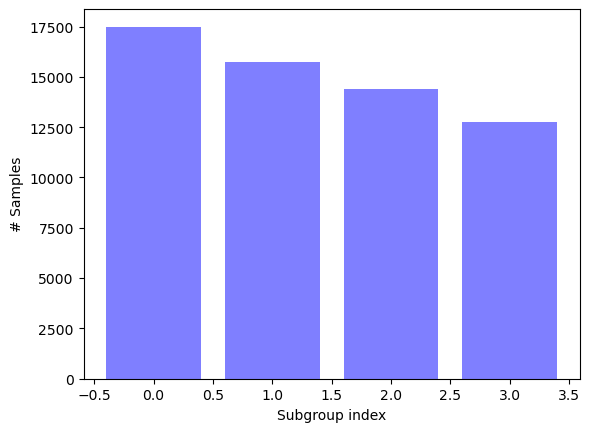

In [54]:
# 서브그룹별 샘플 개수 세기
subgroup_counts = S_df.value_counts().reset_index(name="count")

# 서브그룹 개수
num_subgroups = subgroup_counts.shape[0]

print("서브그룹 개수:", num_subgroups)
import matplotlib.pyplot as plt
plt.bar(range(4), subgroup_counts["count"], alpha=0.5, color = "blue")
plt.xlabel("Subgroup index")
plt.ylabel("# Samples")
plt.savefig("./dutch_subgroup_hist.png")
plt.show()


### adult EDA

In [55]:
import pandas as pd, numpy as np, re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch, random

# 시드 고정
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# -----------------------
# 1. 데이터 불러오기
# -----------------------
df = pd.read_csv("../data/raw/adult.csv")

# 가벼운 정리
df.columns = [c.strip() for c in df.columns]
lower = {c.lower(): c for c in df.columns}

def alias(old_keys, new_key):
    for k in old_keys:
        if k in lower:
            src = lower[k]
            if new_key not in df.columns:
                df.rename(columns={src: new_key}, inplace=True)
            return

# 컬럼 표준화
alias(["gender", "sex"], "sex")
alias(["educational-num","education_num","educational_num","education-num"], "education-num")
alias(["hours_per_week","hoursperweek","hours-per-week"], "hours-per-week")
alias(["capital_gain","capitalgain","capital-gain"], "capital-gain")
alias(["capital_loss","capitalloss","capital-loss"], "capital-loss")
alias(["native_country","native-country"], "native-country")
alias(["marital_status","marital-status"], "marital-status")

# -----------------------
# 2. 타겟 / X 분리
# -----------------------
y = (df["income"].astype(str).str.strip() == ">50K").astype(int).values
X = df.drop(columns=["income"]).copy()

# 문자열 정리
for c in X.select_dtypes(include=["object"]).columns:
    X[c] = (
        X[c].astype(str).str.strip()
            .replace("?", np.nan)
            .fillna("Unknown")
    )

# -----------------------
# 3. 민감속성 S 생성
# -----------------------
S = {}

if "sex" in X.columns:
    s = X["sex"].astype(str).str.strip()
    S["sex_Male"] = (s == "Male").astype(int)

if "race" in X.columns:
    r = X["race"].astype(str).str.strip()
    S["race_White"] = (r == "White").astype(int)

if "age" in X.columns:
    age = pd.to_numeric(X["age"], errors="coerce")
    S["age_ge_40"] = (age >= 40).astype(int)

if "marital-status" in X.columns:
    ms = X["marital-status"].astype(str).str.strip()
    S["married"] = ms.isin({"Married-civ-spouse","Married-AF-spouse"}).astype(int)

# if "education-num" in X.columns:
#     edu = pd.to_numeric(X["education-num"], errors="coerce").fillna(0)
#     S["edu_bachelor_plus"] = (edu >= 13).astype(int)

# if "native-country" in X.columns:
#     nc = X["native-country"].astype(str).str.strip()
#     S["native_US"] = (nc == "United-States").astype(int)

# if "workclass" in X.columns:
#     wc = X["workclass"].astype(str).str.strip()
#     S["work_gov"]     = wc.isin({"Federal-gov","State-gov","Local-gov"}).astype(int)
#     S["work_private"] = (wc == "Private").astype(int)

# if "occupation" in X.columns:
#     occ = X["occupation"].astype(str).str.strip()
#     S["occ_white_collar"] = occ.isin({"Prof-specialty","Exec-managerial","Tech-support"}).astype(int)
#     S["occ_blue_collar"]  = occ.isin({
#         "Craft-repair","Machine-op-inspct","Handlers-cleaners",
#         "Farming-fishing","Transport-moving","Priv-house-serv"
#     }).astype(int)

# if "hours-per-week" in X.columns:
#     hpw = pd.to_numeric(X["hours-per-week"], errors="coerce").fillna(0)
#     S["hours_ge_50"] = (hpw >= 50).astype(int)

# if "capital-gain" in X.columns:
#     cg = pd.to_numeric(X["capital-gain"], errors="coerce").fillna(0)
#     S["cap_gain_pos"] = (cg > 0).astype(int)

# if "capital-loss" in X.columns:
#     cl = pd.to_numeric(X["capital-loss"], errors="coerce").fillna(0)
#     S["cap_loss_pos"] = (cl > 0).astype(int)

# if "relationship" in X.columns:
#     rel = X["relationship"].astype(str).str.strip()
#     S["rel_husband"] = (rel == "Husband").astype(int)

S_df = pd.DataFrame(S).astype(int)
if S_df.shape[1] == 0 and "sex" in X.columns:
    S_df = pd.DataFrame({"sex_Male": (X["sex"].astype(str).str.strip()=="Male").astype(int)})

print("[adult] S columns =", list(S_df.columns))

# -----------------------
# 4. 특징 전처리 (FE)
# -----------------------
mode = "concat"  # drop, keep, concat 중 선택
sens_raw_all = [c for c in ["sex","race","age","marital-status"] if c in X.columns]

# raw 민감속성 제거
if mode == "drop":
    X_for_fe = X.drop(columns=sens_raw_all, errors="ignore")
elif mode == "concat":
    X_for_fe = X.drop(columns=sens_raw_all, errors="ignore")
else:
    X_for_fe = X.copy()

cat = X_for_fe.select_dtypes(include=["object"]).columns.tolist()
num = X_for_fe.select_dtypes(exclude=["object"]).columns.tolist()

# 범주형 원핫
enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
X_cat = pd.DataFrame(enc.fit_transform(X_for_fe[cat]))
X_cat.columns = enc.get_feature_names_out(cat)

# 수치형 스케일링
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X_for_fe[num]), columns=num)

Xp = pd.concat([X_num, X_cat], axis=1)

# concat 모드 → 민감속성 붙이기
if mode == "concat":
    Xp = pd.concat([Xp.reset_index(drop=True), S_df.reset_index(drop=True)], axis=1)
    Xp = Xp.loc[:, ~Xp.columns.duplicated()]

# -----------------------
# 5. Train/Val/Test split
# -----------------------
X_tr, X_te, y_tr, y_te, S_tr, S_te = train_test_split(
    Xp, y, S_df, test_size=0.2, random_state=42, stratify=y
)
# X_tr, X_va, y_tr, y_va, S_tr, S_va = train_test_split(
#     X_tr, y_tr, test_size=0.2, random_state=42, stratify=y_tr
# )

print("Train:", X_tr.shape, y_tr.shape, S_tr.shape)
# print("Val:", X_va.shape, y_va.shape, S_va.shape)
print("Test:", X_te.shape, y_te.shape, S_te.shape)


[adult] S columns = ['sex_Male', 'race_White', 'age_ge_40', 'married']
Train: (39073, 97) (39073,) (39073, 4)
Test: (9769, 97) (9769,) (9769, 4)


In [56]:
Xp.shape

(48842, 97)

In [57]:
S_df.value_counts()

sex_Male  race_White  age_ge_40  married
1         1           1          1          10667
                      0          0           7949
                                 1           7340
0         1           0          0           6817
                      1          0           4130
1         1           1          0           2779
0         0           0          0           1689
1         0           0          0           1511
0         1           0          1           1116
1         0           1          1           1115
0         0           1          0           1051
          1           1          1            964
1         0           0          1            789
                      1          0            500
0         0           0          1            233
                      1          1            192
dtype: int64

서브그룹 개수: 16


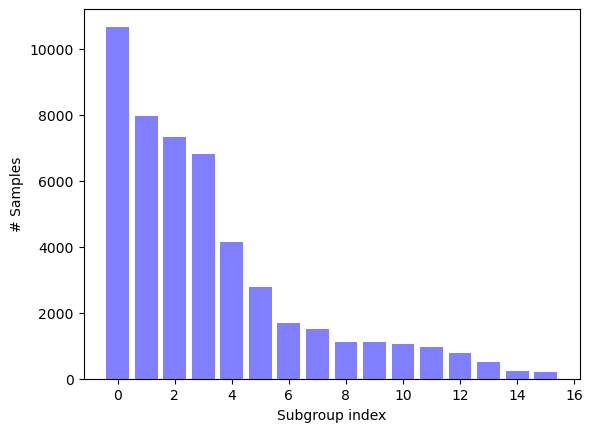

In [58]:
# 서브그룹별 샘플 개수 세기
subgroup_counts = S_df.value_counts().reset_index(name="count")

# 서브그룹 개수
num_subgroups = subgroup_counts.shape[0]

print("서브그룹 개수:", num_subgroups)
import matplotlib.pyplot as plt
plt.bar(range(16), subgroup_counts["count"], alpha=0.5, color = "blue")
plt.xlabel("Subgroup index")
plt.ylabel("# Samples")
plt.savefig("./adult_subgroup_hist.png")
plt.show()


### Communities EDA

In [59]:
import pandas as pd, numpy as np, re
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch, random

# 시드 고정
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ------------------------
# 1. 파일 읽기
# ------------------------
def _normalize_colname(name: str) -> str:
    name = name.lower().strip().replace("\t", " ")
    name = re.sub(r'[^a-z0-9_]', '', name)
    return name

def _parse_names_smart(names_path: Path, ncols: int):
    if not names_path.exists():
        return []
    allowed = ("continuous", "integer", "real", "numeric", "binary", "nominal")
    cand = []
    with open(names_path, "r", encoding="utf-8", errors="ignore") as f:
        for raw in f:
            line = raw.strip()
            if not line or line.startswith("|") or line.startswith("#"):
                continue
            if ":" not in line:
                continue
            left, right = line.split(":", 1)
            if any(tok in right.lower() for tok in allowed):
                name = _normalize_colname(left)
                if name:
                    cand.append(name)
    if len(cand) == ncols:
        return cand
    if len(cand) > ncols:
        return cand[-ncols:]
    return []

data_dir = "../data/raw"
data_path = Path(data_dir) / "communities.data"
names_path = Path(data_dir) / "communities.names"

df = pd.read_csv(
    data_path,
    header=None,
    na_values=["?"],
    dtype=None,
    skipinitialspace=True
)
ncols = df.shape[1]
header = _parse_names_smart(names_path, ncols)
if header:
    df.columns = header
else:
    df.columns = [f"col{i}" for i in range(ncols)]
    print(f"[WARN] failed to parse names, fallback colN")

df.columns = [_normalize_colname(c) for c in df.columns]
print("[communities] first 10 cols:", list(df.columns[:10]))

# ------------------------
# 2. 타겟 만들기
# ------------------------
target_candidates = [c for c in df.columns if "violent" in c and "perpop" in c]
target_col = target_candidates[0] if len(target_candidates) else df.columns[-1]
y_cont = pd.to_numeric(df[target_col], errors="coerce").fillna(0.0)
thr70 = y_cont.quantile(0.70)
y = (y_cont > thr70).astype(int).values

# ------------------------
# 3. 보호(민감) 속성
# ------------------------
_PRESET_SENS = {
    "paper18": [
        "racepctwhite","racepctblack","racepctasian","racepcthisp",
        "whitepercap","blackpercap","indianpercap","asianpercap","otherpercap","hisppercap",
        "pctnotspeakenglwell","pctforeignborn",
        "pctimmigrecent","pctimmigrec5","pctimmigrec8","pctimmigrec10",
        "pctrecentimmig","pctrecimmig5",
    ],
    "race_basic": ["racepctwhite","racepctblack","racepctasian","racepcthisp"],
    "socio_basic": ["pctpopunderpov","pcthsdropout","pctunemployed","medfaminc"],
    "auto": ["racepctblack","pctpopunderpov","pctunemployed"]
}

def _binarize_quantile_strict(series: pd.Series, q: float = 0.5) -> pd.Series:
    v = pd.to_numeric(series, errors="coerce")
    finite = v.dropna()
    m = pd.Series(0, index=v.index, dtype=int)
    if finite.empty:
        return m
    try:
        cats = pd.qcut(finite, q=[0,q,1], labels=[0,1], duplicates="drop")
        if cats.nunique() == 2:
            m.loc[cats.index] = cats.astype(int)
            return m
    except Exception: pass
    try:
        thr = finite.quantile(q)
        m2 = (v > thr).astype(int)
        if m2.nunique() == 2:
            return m2
    except Exception: pass
    thr = finite.median()
    m3 = (v > thr).astype(int)
    if m3.nunique() == 2:
        return m3
    thr = finite.mean()
    m4 = (v > thr).astype(int)
    if m4.nunique() == 2:
        return m4
    order = finite.rank(method="first")
    kcut = order.median()
    m.loc[order.index] = (order > kcut).astype(int).values
    return m.astype(int)

sens_keys = "paper18"
sens_thresh = 0.5

keys = _PRESET_SENS[sens_keys]
S, used, dropped = {}, [], []
for k in keys:
    if k not in df.columns:
        dropped.append(k)
        continue
    m = _binarize_quantile_strict(df[k], q=sens_thresh)
    if m.nunique() < 2:
        dropped.append(k)
        continue
    S[f"{k}_high"] = m.astype(int).values
    used.append(k)

S_df = pd.DataFrame(S).astype(int) if len(S) > 0 else pd.DataFrame({"dummy_s":np.zeros(len(df),dtype=int)})

print("[communities] target_col:", target_col, "| thr70:", float(thr70))
print("[communities] S used:", used)
print("[communities] S dropped:", dropped)
print("[communities] S cols(final):", list(S_df.columns))
print("[communities] S positives:", S_df.sum().to_dict())

# ------------------------
# 4. X 전처리
# ------------------------
id_like = [c for c in ["state","county","community","communityname","fold"] if c in df.columns]
X_raw = df.drop(columns=[target_col]+id_like, errors="ignore")

x_mode = "concat"  # drop, concat, keep 중 선택
if x_mode == "drop":
    X_for_fe = X_raw.drop(columns=used, errors="ignore")
else:
    X_for_fe = X_raw.copy()

X_for_fe = X_for_fe.apply(pd.to_numeric, errors="ignore")
X_num = X_for_fe.select_dtypes(include=[np.number]).copy()
X_num = X_num.fillna(X_num.median(numeric_only=True))

scaler = StandardScaler()
Xp = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)

if x_mode == "concat" and S_df.shape[1] > 0:
    Xp = pd.concat([Xp.reset_index(drop=True), S_df.reset_index(drop=True)], axis=1)

# ------------------------
# 5. Split
# ------------------------
X_tr, X_te, y_tr, y_te, S_tr, S_te = train_test_split(
    Xp, y, S_df, test_size=0.2, random_state=42, stratify=y
)
X_tr, X_va, y_tr, y_va, S_tr, S_va = train_test_split(
    X_tr, y_tr, S_tr, test_size=0.2, random_state=42, stratify=y_tr
)

print("Train:", X_tr.shape, y_tr.shape, S_tr.shape)
print("Val:", X_va.shape, y_va.shape, S_va.shape)
print("Test:", X_te.shape, y_te.shape, S_te.shape)


[communities] first 10 cols: ['attributecharacteristics', 'state', 'county', 'community', 'fold', 'population', 'householdsize', 'racepctblack', 'racepctwhite', 'racepctasian']
[communities] target_col: violentcrimesperpop | thr70: 0.28
[communities] S used: ['racepctwhite', 'racepctblack', 'racepctasian', 'racepcthisp', 'whitepercap', 'blackpercap', 'indianpercap', 'asianpercap', 'otherpercap', 'hisppercap', 'pctnotspeakenglwell', 'pctforeignborn', 'pctimmigrecent', 'pctimmigrec5', 'pctimmigrec8', 'pctimmigrec10', 'pctrecentimmig', 'pctrecimmig5']
[communities] S dropped: []
[communities] S cols(final): ['racepctwhite_high', 'racepctblack_high', 'racepctasian_high', 'racepcthisp_high', 'whitepercap_high', 'blackpercap_high', 'indianpercap_high', 'asianpercap_high', 'otherpercap_high', 'hisppercap_high', 'pctnotspeakenglwell_high', 'pctforeignborn_high', 'pctimmigrecent_high', 'pctimmigrec5_high', 'pctimmigrec8_high', 'pctimmigrec10_high', 'pctrecentimmig_high', 'pctrecimmig5_high']
[c

In [60]:
Xp.shape

(1994, 141)

In [61]:
# 서브그룹별 샘플 개수 세기
subgroup_counts = S_df.value_counts().reset_index(name="count")

# 서브그룹 개수
num_subgroups = subgroup_counts.shape[0]

print("서브그룹 개수:", num_subgroups)
print(subgroup_counts["count"][:44])

서브그룹 개수: 1180
0     51
1     36
2     27
3     20
4     20
5     17
6     15
7     15
8     13
9     12
10    12
11    10
12    10
13    10
14     9
15     9
16     8
17     8
18     7
19     7
20     7
21     7
22     7
23     7
24     7
25     7
26     7
27     7
28     6
29     6
30     6
31     6
32     6
33     6
34     6
35     5
36     5
37     5
38     5
39     5
40     5
41     5
42     5
43     5
Name: count, dtype: int64


서브그룹 개수: 1180


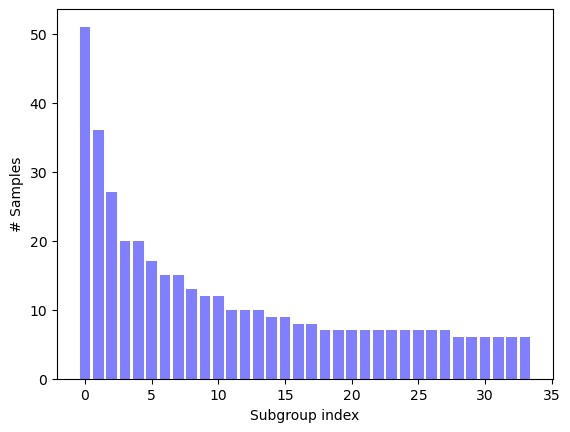

In [62]:
# 서브그룹별 샘플 개수 세기
subgroup_counts = S_df.value_counts().reset_index(name="count")

# 서브그룹 개수
num_subgroups = subgroup_counts.shape[0]

print("서브그룹 개수:", num_subgroups)
import matplotlib.pyplot as plt
plt.bar(range(34), subgroup_counts["count"][:34], alpha=0.5, color = "blue")
plt.xlabel("Subgroup index")
plt.ylabel("# Samples")
plt.savefig("./communities_subgroup_hist.png")
plt.show()


### CivilComments

### dist 분석

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

def plot_hist(score_path, y_path, s_path, bins=50):
    p = np.load(score_path).ravel()
    y = np.load(y_path).ravel()
    s = np.load(s_path).ravel()

    if p.shape[0] != y.shape[0]:
        n = min(p.shape[0], y.shape[0])
        print(f"[warn] length mismatch: proba={p.shape[0]}, y={y.shape[0]} → trimmed to {n}")
        p, y = p[:n], y[:n]
    import pdb; pdb.set_trace()
    p1 = p[(y==1)&(s == 1)]
    p0 = p[(y==1)&(s == 0)]

    bins = np.linspace(0.0, 1.0, bins + 1)
    plt.figure()
    # y=0: 투명 파랑, y=1: 투명 빨강
    plt.hist(p1, bins=bins, alpha=0.45, color="red",   edgecolor="black", label="s=1", density=True)
    plt.hist(p0, bins=bins, alpha=0.45, color="blue",  edgecolor="black", label="s=0", density=True)
    

    plt.legend()
    plt.xlabel("Predicted probability")
    plt.ylabel("Density")
    plt.title(Path(score_path).name)
    plt.tight_layout()
    plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_hist2(score_path, y_path, s_path, bins=50, min_count=1):
    p = np.load(score_path).ravel()
    y = np.load(y_path).ravel()
    s = np.load(s_path)
    print(s)

    # 길이 맞추기
    if s.ndim == 1:
        s = s.reshape(-1, 1)
    n = min(p.shape[0], y.shape[0], s.shape[0])
    if (p.shape[0], y.shape[0], s.shape[0]) != (n, n, n):
        print(f"[warn] length mismatch → trimmed to {n}")
    p, y, s = p[:n], y[:n], s[:n]

    # ★ 여기서 y==1만 사용
    mask_pos = (y == 1)
    if mask_pos.sum() == 0:
        print("[warn] no positive (y==1) samples to plot"); return
    p, s = p[mask_pos], s[mask_pos]

    # 이진(0/1) 보정
    s = (s > 0.5).astype(np.int64)

    # 유니크 조합 → 비트코드
    q = s.shape[1]
    weights = (1 << np.arange(q, dtype=np.int64))  # [1,2,4,8,...]
    codes = (s * weights).sum(axis=1)              # (N_pos,)
    uniq, inv = np.unique(codes, return_inverse=True)

    # 그룹 인덱스 수집(+ 최소 지지도 필터)
    groups = [(g, np.where(inv == i)[0]) for i, g in enumerate(uniq)]
    groups = [(g, idxs) for g, idxs in groups if idxs.size >= min_count]
    if len(groups) == 0:
        print("[warn] no groups to plot after filtering"); return

    # 히스토그램
    edges = np.linspace(0.0, 1.0, bins + 1)
    cmap = plt.get_cmap('tab20', len(groups))
    plt.figure()
    for i, (g, idxs) in enumerate(groups):
        plt.hist(
            p[idxs], bins=edges, alpha=0.45, edgecolor="black",
            label=f"group {i+1} (n={idxs.size})", color=cmap(i), density=True
        )

    # (선택) 그룹 매핑 출력: id -> 비트패턴(LSB=첫 번째 열)
    print("Group mapping (id → bit pattern among y==1, LSB=col0):")
    for i, (g, idxs) in enumerate(groups):
        bitstr = "".join(str((g >> j) & 1) for j in range(q))
        print(f"  {i+1}: {bitstr} (n={idxs.size})")

    plt.legend(title="group id (y==1)")
    plt.xlabel("Predicted probability")
    plt.ylabel("Density")
    plt.title(Path(score_path).name + f" | {len(groups)} groups (y==1 only)")
    plt.tight_layout()
    plt.show()


[ 5 15 15 ...  2  5  6]
Group mapping (id → bit pattern among y==1, LSB=col0):
  1: 1 (n=2091)


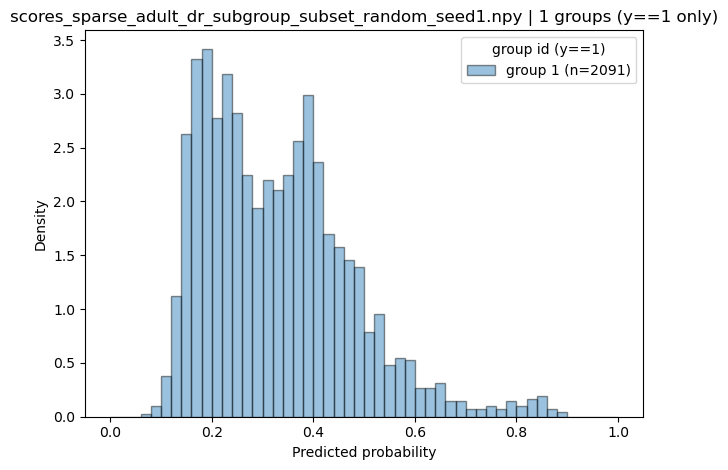

[11  5 13 ... 13  5 14]
Group mapping (id → bit pattern among y==1, LSB=col0):
  1: 1 (n=2338)


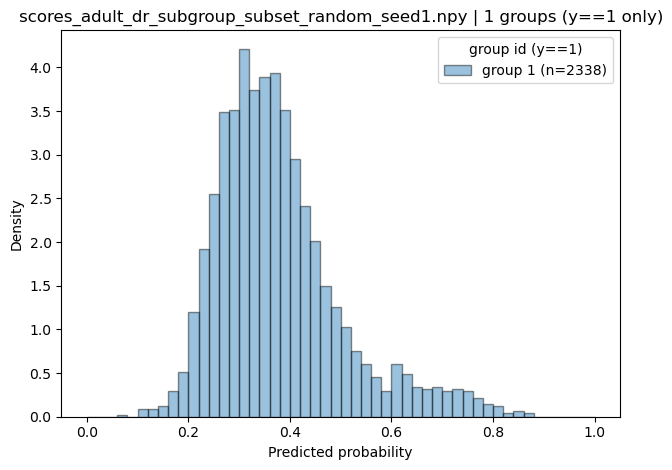

[ 5 15 15 ...  2  5  6]
Group mapping (id → bit pattern among y==1, LSB=col0):
  1: 1 (n=2091)


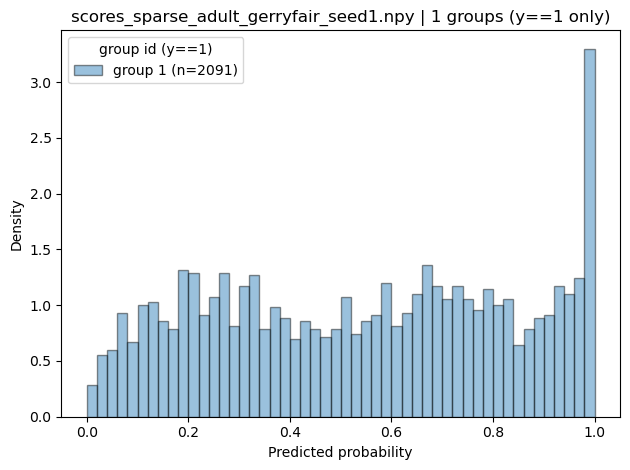

[11  5 13 ... 13  5 14]
Group mapping (id → bit pattern among y==1, LSB=col0):
  1: 1 (n=2338)


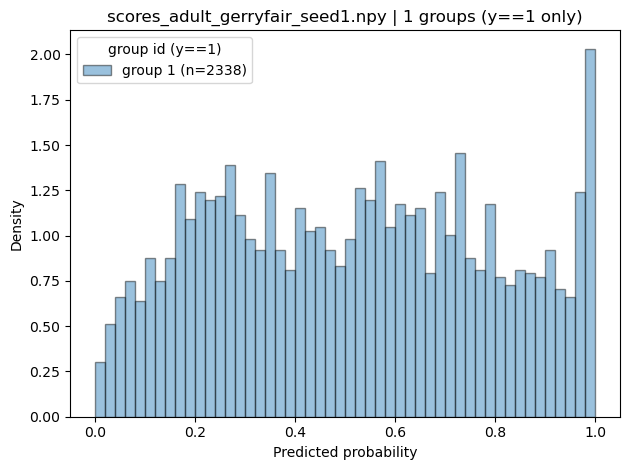

[ 5 15 15 ...  2  5  6]
Group mapping (id → bit pattern among y==1, LSB=col0):
  1: 1 (n=2091)


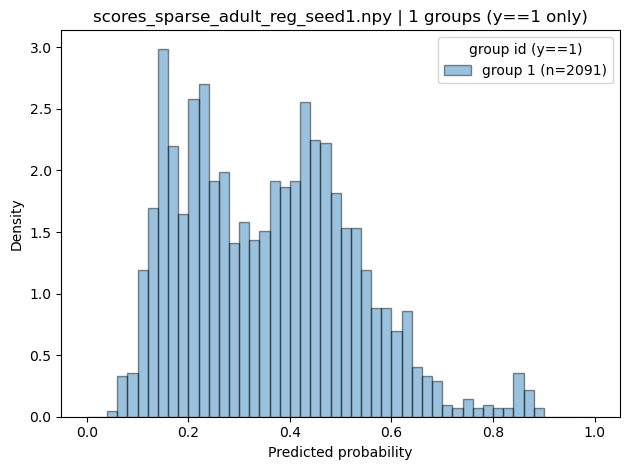

[11  5 13 ... 13  5 14]
Group mapping (id → bit pattern among y==1, LSB=col0):
  1: 1 (n=2338)


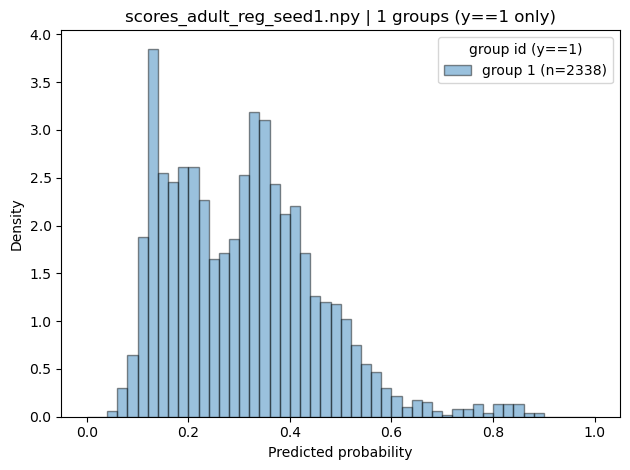

[ 5 15 15 ...  2  5  6]
Group mapping (id → bit pattern among y==1, LSB=col0):
  1: 1 (n=2091)


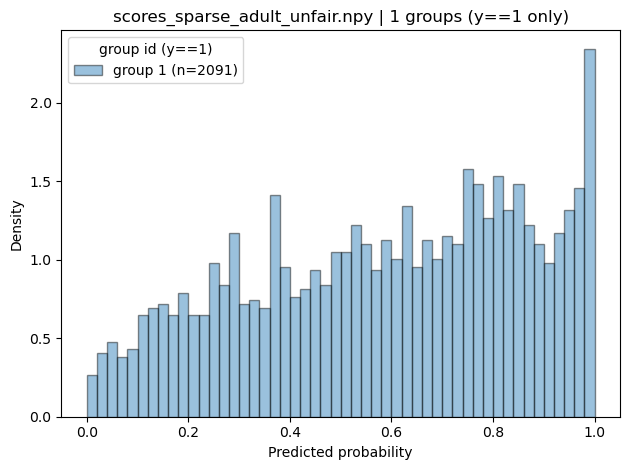

[11  5 13 ... 13  5 14]
Group mapping (id → bit pattern among y==1, LSB=col0):
  1: 1 (n=2338)


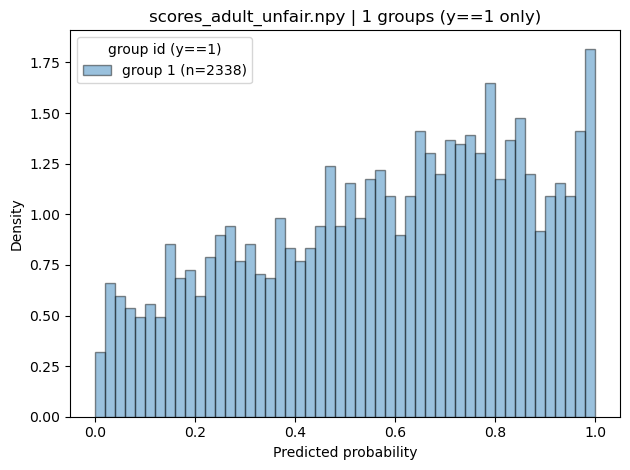

In [ ]:
scores_dir = Path("../scores3")
cand = sorted(scores_dir.glob("scores_*.npy"), key=lambda p: p.stat().st_mtime, reverse=True)
if not cand:
    raise SystemExit("No scores_*.npy found in ../scores")
for i in range(len(cand)):
    d_path = cand[i]
    y_path = d_path.with_name(d_path.name.replace("scores_", "truey_"))
    s_path = d_path.with_name(d_path.name.replace("scores_", "trues_"))
    if not y_path.exists():
        raise SystemExit(f"Missing y file: {y_path.name}")
    plot_hist2(str(d_path), str(y_path), str(s_path))

In [ ]:
getattr(args, "seq_alpha", None)

0.1

In [7]:
from sklearn.model_selection import train_test_split
from fairbench.utils.trainval import split_train_val
import numpy as np

n = 20000; d = 20; q = 2
assert d > q, f"d must be larger than q, but got d={d}, q={q}"
rng = np.random.default_rng(args.seed)
X = rng.normal(size=(n, d)).astype(np.float32)

# latent sensitive factors (q binary), correlated with some features
S = (rng.normal(size=(n, q)) + 0.5*X[:, :min(d, q)][:, None]).mean(axis=1, keepdims=True)
S = (rng.normal(size=(n, q)) > 0.0).astype(int)  # 독립적인 q도 가능
S = pd.DataFrame(S, columns=[f"s{j}" for j in range(q)])

# target: non-linear function + mild spurious corr with a few sensitive attrs
logits = 0.8*X[:,0] - 0.6*X[:,1] + 0.5*X[:,2]*X[:,3] + 0.2*(S.values[:,:min(q,5)].sum(axis=1))
p = 1/(1+np.exp(-logits))
y = (rng.uniform(size=n) < p).astype(int)

X = pd.DataFrame(X, columns=[f"x{j}" for j in range(d)])

X_tr, X_te, y_tr, y_te, S_tr, S_te = train_test_split(X, y, S, test_size=0.2, random_state=args.seed, stratify=y)
X_tr, X_va, y_tr, y_va, S_tr, S_va = split_train_val(X_tr, y_tr, S_tr, val_size=0.2, seed=args.seed)


In [8]:
S

,s0,s1
0,0,1
1,0,1
2,0,0
3,1,0
4,1,1
...,...,...
19995,1,1
19996,0,1
19997,0,1
19998,1,0


In [11]:

n = 20000; d = 20; q = 2
assert d > q, f"d must be larger than q, but got d={d}, q={q}"
rng = np.random.default_rng(args.seed)
X = rng.normal(size=(n, d)).astype(np.float32)

(rng.normal(size=(n, q)) + 0.5*X[:, :min(d, q)][:, None]).mean(axis=1, keepdims=True)

array([[[ 0.13617472, -0.5246417 ]],

       [[-0.108615  , -0.34511442]],

       [[ 0.35544327,  0.26692747]],

       ...,

       [[ 0.04899138,  0.0732359 ]],

       [[-0.95700005, -0.67619325]],

       [[ 0.33115828,  0.19019868]]])

In [2]:
import pandas as pd

df = pd.read_csv("results_0909/dr_subgroup_subset_3q_adult/all_results.csv")

In [4]:
df.columns

Index(['timestamp', 'exp_name', 'dataset', 'method', 'seed', 'x_sensitive',
       'sens_keys', 'sens_thresh', 'epochs', 'batch_size', 'lr', 'lambda_fair',
       'n_low', 'n_low_frac', 'shrink_smallest_frac', 'shrink_seed', 'gamma',
       'gf_max_iters', 'gf_C', 'gf_fairness', 'mc_alpha', 'mc_lambda',
       'mc_max_iter', 'mc_randomized', 'mc_use_oracle', 'seq_alpha',
       'seq_max_iter', 'red_constraint', 'red_eps', 'red_max_iter', 'red_base',
       'x_sensitive_mode', 'used_S_cols', 'dropped_cols', 'start_time',
       'end_time', 'time_prepare_data_sec', 'time_run_method_sec',
       'time_metrics_sec', 'time_total_sec', 'V_stats', 'accuracy',
       'supipm_rbf', 'supipm_w1', 'sup_mmd_dfcols', 'sup_w1_dfcols',
       'sup_mmd_over_V', 'sup_w1_over_V', 'spd_worst', 'spd_mean',
       'worst_weighted_group_spd', 'mean_weighted_group_spd',
       'worst_spd_over_V', 'mean_spd_over_V', 'worst_weighted_spd_over_V',
       'mean_weighted_spd_over_V', 'fpr_worst', 'fpr_mean', 'mc_wo